In [348]:
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys

import os


In [349]:
sys.setrecursionlimit(6000) #doubled recusion limit LOL

## Import Files From Simulation:

In [350]:
# no_interactions_file = "C:\\users/tmhab/wlcsim_membrane/data/2.10.21_NoInteractions_2hrs_r11v0.txt"
# no_interactions_data = np.loadtxt(no_interactions_file) #D:\\myfiles\welcome.txt

# ABmelt_file = "C:\\users/tmhab/wlcsim_membrane/data/4.05.21_ABmelt_3hrs_r6v0.txt"
# ABmelt_data = np.loadtxt(ABmelt_file)

# ABsolution_file = "C:\\users/tmhab/wlcsim_membrane/data/3.30.21_ABrandomCopolymerSoln_4hrs_r6v0.txt"
# ABsolution_data = np.loadtxt(ABsolution_file)

#testing if msd correponds to equilibration

In [351]:
r_path = "C:\\Users/Thomas/Desktop/test_of_equilibration/"


## Our Approach to Calculating Percolation Paths Through a Polymer Membrane:

### Defining The System:

In our system we have random copolymers with solvent molecules. Polymers are represented by beads of types 1 and 2 and solvent molecules are individual beads of type 0. No bead can overlap another. 

### Defining Percolation:

A percolation is a pathway through the polymer network that solvent molecules can move through. To form a percolation a solvent molecule will need to have at least one other solvent molecule adjacent to it within some path radius $r$

### What are we trying to learn from the system:

The goal in developing this code is to determine quantitatively the amount of percolation in a membrane. 

### Models for Percolation:
**1. Fire Spread Model:** In this model we measure the percolation paths by tracing the spots where the solvent molecules continue to be adjacent to the previous... It's easier to explain with a picture

## What we need to calculate:

Starting with the final equilibrium state we have x,y,z postion of a bead and it's identity (and also methylation state). We want to calculate percolation paths which will be represented by root mean square. 

#### What Percolation Model do we want to use:

1. Fire spead model:

Proceedure:
1. Pick a bead type
2. pick a random bead of that bead type
3. Check surround bead types to see if they are the same
    a. Pick a radius to search in


# Note: for some reason if you declare two different PolymerNetworks, they can interfere w/ each other (change values)

In [352]:
def generate_test_data(length=10,width=10,height=10,datapoints=500):
    X = np.random.random(datapoints)*length
    Y = np.random.random(datapoints)*width
    Z = np.random.random(datapoints)*height
    Beads = np.random.randint(1,size=(datapoints)).astype('uint8')
    Beads
    return X,Y,Z,Beads

#generate_test_data()

In [353]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
    
    def print_bead(self):
        print("x: ", self.x)
        print("Y: ", self.y)
        print("Z: ", self.z)
        


In [354]:
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = bead_list
        bead_coor_array = np.zeros((len(bead_list), 3))
        bead_types = np.zeros(len(bead_list))
        for i, bead in enumerate(bead_list):
            bead_coor_array[i, 0] = bead.x
            bead_coor_array[i, 1] = bead.y
            bead_coor_array[i, 2] = bead.z
            bead_types[i] = bead.bead_type
        self.bead_coor_array = bead_coor_array
        self.bead_types = bead_types
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   
    def find_center_of_mass(self,bead_num=0): 
        '''
        Find the center of mass for a given polymer chain wrt to a specific bead type
        '''
        #print("IN COM METHOD")
        X_bead = self.bead_coor_array[:,0][self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1][self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2][self.bead_types==bead_num]
        
        x_center = np.mean(X_bead)
        y_center = np.mean(Y_bead)
        z_center = np.mean(Z_bead)
        
        #print("COM: ", [x_center,y_center,z_center])
        return [x_center,y_center,z_center]
    
    def find_rg2(self): # INCORRECT- need to divid by total num of beads
        center_of_mass = self.find_center_of_mass()
        displacements = self.bead_coor_array - center_of_mass
        displacements_square = np.square(displacements)
        final_disp = np.sum(displacements_square, axis=1) #final disp square of sub polymer beads
        
        radius_g_2 = np.sum(final_disp)
        
        return radius_g_2
    
    def Radius_of_gyration_2(self,bead_num=0):
        center_of_mass_point = self.find_center_of_mass(bead_num)
        
        X_bead = self.bead_coor_array[:,0][self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1][self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2][self.bead_types==bead_num]
        
        n = X_bead.shape[0]
        
        Rg2 = (np.sum((X_bead - center_of_mass_point[0])**2 + 
                    (Y_bead - center_of_mass_point[1])**2 + (Z_bead - center_of_mass_point[2])**2)/n)
        #print("IN RADIUG OF GYR METHOD")
        #print("Rg2:", Rg2)
        return Rg2

In [355]:
class PercolationPath:
    '''
    List of all beads that make a percolation path
    '''
    
    def __init__(self, beads_in_path=[]):
        self.beads_in_path = beads_in_path
        self.bead_coor_array = []
        self.bead_types = []
    
    def print_path(self):
        for i, bead in enumerate(self.beads_in_path):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def make_bead_coor_array(self):
        bead_coor_array = np.zeros((len(self.beads_in_path), 3))
        bead_types = np.zeros(len(self.beads_in_path))
        for i, bead in enumerate(self.beads_in_path):
            bead_coor_array[i, 0] = bead.x
            bead_coor_array[i, 1] = bead.y
            bead_coor_array[i, 2] = bead.z
            bead_types[i] = bead.bead_type
        self.bead_coor_array = bead_coor_array
        self.bead_types = bead_types
        

In [356]:
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, persistence_length=2.03):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = []
        self.polymer_list = []
        self.persistence_length = persistence_length
        self.create_beads()
        self.create_polymers()
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[self.Beads==0], self.Y[self.Beads==0], self.Z[self.Beads==0],color='y')
        ax.scatter3D(self.X[self.Beads==1], self.Y[self.Beads==1], self.Z[self.Beads==1],color='r')
        ax.scatter3D(self.X[self.Beads==2], self.Y[self.Beads==2], self.Z[self.Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        #if not hasattr(self, "bead_list"):
        if len(self.bead_list) == 0:
            for i in range(len(self.X)):
                bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
                self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        #if not hasattr(self, "polymer_list") and hasattr(self, "bead_list"):
        if len(self.polymer_list) == 0 and len(self.bead_list) > 0:
            for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
                polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
                self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()
# '''
# Finds all posible percolation paths in the polylmer network, then plots them. Color indicates the number of beads in 
# the path
# '''
    def visualize_percolation_paths(self,connection_radius, x_lim = 1, y_lim = 1, z_lim = 1, bead_num=0):
        #NEED TO MAKE MUCH FASTER!!!
        X_bead = self.X[self.Beads==bead_num]
        Y_bead = self.Y[self.Beads==bead_num]
        Z_bead = self.Z[self.Beads==bead_num]
        
        #Build array to see if a bead has been used in a percolation collection yet (True means it hasn't been used)
        ALL_PATHS = []  

        
#         bead = self.bead_list[4]
#         starting_path = PercolationPath([bead])
#         self.find_all_percolation_paths(starting_path, connection_radius, bead_num=0)
#         #print("beads in path: ", starting_path.print_path())
#         ALL_PATHS.append(starting_path)

        ALL_PATHS = self.find_all_percolation_paths(connection_radius, bead_num)
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        #print(len(ALL_PATHS))
        max_path = PercolationPath([])
        max_length = 0
        
        for path in ALL_PATHS:
            if len(path.beads_in_path) > len(max_path.beads_in_path):
                max_path = path
                max_length = len(max_path.beads_in_path)
            
        for path in ALL_PATHS:
            color = cm.rainbow(len(path.beads_in_path)/max_length - .01)
            path.make_bead_coor_array()
            X_vals = path.bead_coor_array[:, 0]
            Y_vals = path.bead_coor_array[:, 1]
            Z_vals = path.bead_coor_array[:, 2]
            ax.scatter3D(X_vals, Y_vals, Z_vals, color=color)
        plt.xlim([0, x_lim])
        plt.ylim([0, y_lim])
        ax.set_zlim(0, z_lim)
        return len(ALL_PATHS)

# '''
# Finds all posible percolation paths within the polymer network. 
# Returns a list of percolation paths, which contain the list of beads in the given path
# '''
    def find_all_percolation_paths(self, connection_radius, bead_num=0):
        all_paths = []
        pathed_beads = []
        for i, bead in enumerate(self.bead_list): # try all beads as starting bead to find percoaltion path
            if i % 10000 == 0: # to monitor progress
                print("on bead: ", i)
                print("pathed_beads", len(pathed_beads))
            if (bead not in pathed_beads) and (bead.bead_type == bead_num): # no repeat beads
                starting_path = PercolationPath([bead])
                self.find_percolation_path(starting_path, connection_radius, bead_num)
                #print("beads in path: ", starting_path.print_path())
                all_paths.append(starting_path)
                #print("old length of pathed beads", len(pathed_beads))
                pathed_beads += starting_path.beads_in_path
                #print("new length of pathed beads", len(pathed_beads))
                
        return all_paths

# '''
# Recursively finds a single percolation path given a current path with at least on bead in it.
# Modifies current_path in place to be updated with all beads that make up a percolation path
# '''    
    def find_percolation_path(self, current_path, connection_radius, bead_num):
        last_bead = current_path.beads_in_path[-1]
        avail_beads = self.find_available_beads(last_bead, connection_radius, bead_num)
        #print("Last bead")
        #print(last_bead.print_bead())
        #print("Avail beads:")
        #for bead in avail_beads:
            #bead.print_bead()
        #base case- avail beads is empty, then do nothing
        
        #recursive case:
        for bead in avail_beads:
            if bead not in current_path.beads_in_path:
                #print("efore adding bead: ", current_path.print_path)
                current_path.beads_in_path.append(bead)
                #print("after adding bead: ", current_path.print_path)
                self.find_percolation_path(current_path, connection_radius, bead_num)
            #return current_path
        
# '''
# Finds all beads that are within the connection radius and have the given bead number
# '''        
    def find_available_beads(self, bead, connection_radius, bead_num):
        #print("stuck on avail beads?")
        available_beads = []
        displacement = np.sqrt((self.X - bead.x)**2 + (self.Y - bead.y)**2 + (self.Z - bead.z)**2)
        neighbor_beads_index = np.where([displacement<=connection_radius])[1]
        #print("neighbor_beads indices", neighbor_beads_index)
        #NEED TO FIND, OF THESE NEIGHBOR BEADS, WHICH IS THE FURTHEST??
        for j in neighbor_beads_index:
            neighbor_bead = self.bead_list[j]
            if neighbor_bead.bead_type == bead_num:
                available_beads.append(neighbor_bead)
                
        return available_beads
    
    '''
    find <r_g^2> for full lenght polymers in the network
    '''
    def find_rg2(self):
        rad_g = np.array([])
        for poly in self.polymer_list:
            rad_g = np.append(rad_g, poly.Radius_of_gyration_2())
        return np.average(rad_g)

In [357]:
# #TEST DATA:

# X,Y,Z,Beads = generate_test_data(datapoints = 100)
# PNet_Test = PolymerNetwork(X,Y,Z,np.zeros(len(X)), beads_per_polymer = 1)
# PNet_Test.density

In [358]:
# PNet_Test.visualize()

In [359]:

# PNet_Test.nearest_neighbor(bead_num=0,radius=0.4)
# polym = PNet_Test.polymer_list[0]
# polym.print_bead_list()
# print(polym.find_center_of_mass())
# print(polym.Radius_of_gyration())

In [360]:
#radii = np.linspace(0,15,100)
#for r in radii:
#    plt.plot(r,PNet_Test.nearest_neighbor(bead_num=0,radius=r),'y.')
#plt.xlabel('Radius')
#plt.ylabel('Average Number of Neighbor Points')

In [361]:
#x = r2(PNet_Test)
#x  # roughly random dist (no polymer chain)

In [362]:
# #NO INTERACTIONS DATA:

# beads = np.zeros(len(no_interactions_data[:, 0]))   # no chemical identity data
# no_interactions = PolymerNetwork(no_interactions_data[:, 0], no_interactions_data[:, 1], no_interactions_data[:, 2], beads, beads_per_polymer=40)
# print(len(no_interactions.bead_list)) # should be 80,000
# print(len(no_interactions.polymer_list)) #should be 2000

In [363]:
print(len(poly_ntwrk_list[0][1].polymer_list))

1500


In [364]:
poly_ntwrk_list[0][1].X[:10]

array([1.467657, 1.467657, 1.467657, 1.467657, 1.467657, 1.467657,
       1.467657, 1.467657, 1.467657, 1.467657])

In [365]:
# load in phi files
#no_interactions_data = np.loadtxt(no_interactions_file)
import operator
os.chdir(r_path)

poly_ntwrk_list = []
svpnt_val_list = []
for file in os.listdir():
    file_path = f"{r_path}\{file}"
    
    svpnt_val = file_path[-5:-3]
    if svpnt_val[0] == "r":
        svpnt_val = svpnt_val[1]
    svpnt_val = int(svpnt_val) # 
    
    sim_data = np.loadtxt(file_path)
    beads = sim_data[:, 3]
    poly_netwrk = PolymerNetwork(sim_data[:, 0], sim_data[:, 1], sim_data[:, 2], beads, beads_per_polymer=40)
    #file_df = pd.read_csv(file_path, delimiter = "   |  -", names = ["Vol_A", "Vol_B"])
    
    poly_ntwrk_list.append([svpnt_val, poly_netwrk])
    svpnt_val_list.append(svpnt_val)
    #del poly_netwrk

poly_ntwrk_list = sorted(poly_ntwrk_list, key=operator.itemgetter(0))
svpnt_val_list = sorted(svpnt_val_list)

In [366]:
print(svpnt_val_list)

[0, 1, 4, 6, 7, 8, 10, 13, 16, 18, 20, 23, 24, 25, 26, 30, 31, 32, 33, 34, 38]


In [367]:
# #SUBSET OF NO INTERACTIONS DATA:
# num_beads_sub = 40
# beads = np.zeros(len(no_interactions_data[:num_beads_sub, 0]))
# no_interactions_subset = PolymerNetwork(no_interactions_data[:num_beads_sub, 0], no_interactions_data[:num_beads_sub, 1], no_interactions_data[:num_beads_sub, 2], beads, beads_per_polymer=40)
# print(len(no_interactions_subset.bead_list)) #num_beads_sub
# print(len(no_interactions_subset.polymer_list)) #num_beads_sub/40

In [368]:
# # AB SOLUTION DATA:
# ABsolution = PolymerNetwork(ABsolution_data[:, 0], ABsolution_data[:, 1], ABsolution_data[:, 2], ABsolution_data[:, 3], beads_per_polymer=40)
# print(len(ABsolution.bead_list)) # should be 80,000
# print(len(ABsolution.polymer_list)) #should be 2000

In [369]:
# # SUBSET OF AB SOLTUION DATA: 
# num_beads_sub = 20000
# ABsolution_subset = PolymerNetwork(ABsolution_data[:num_beads_sub, 0], ABsolution_data[:num_beads_sub, 1], ABsolution_data[:num_beads_sub, 2], ABsolution_data[:num_beads_sub, 3], beads_per_polymer=40)
# print(len(ABsolution_subset.bead_list)) #num_beads_sub
# print(len(ABsolution_subset.polymer_list)) #num_beads_sub/40

In [370]:

# # AB MELT DATA:
# ABmelt = PolymerNetwork(ABmelt_data[:, 0], ABmelt_data[:, 1], ABmelt_data[:, 2], ABmelt_data[:, 3], beads_per_polymer=40)
# print(len(ABmelt.bead_list)) # should be 80,000
# print(len(ABmelt.polymer_list)) #should be 2000

In [371]:
# # SUBSET OF AB MELT DATA: 
# num_beads_sub = 20000
# ABmelt_subset = PolymerNetwork(ABmelt_data[:num_beads_sub, 0], ABmelt_data[:num_beads_sub, 1], ABmelt_data[:num_beads_sub, 2], ABmelt_data[:num_beads_sub, 3], beads_per_polymer=40)
# print(len(ABmelt_subset.bead_list)) #num_beads_sub
# print(len(ABmelt_subset.polymer_list)) #num_beads_sub/40

# Percolation Paths

### Using test data

In [372]:
# CLUSTER TEST DATA
def generate_clustered_data(datapoints=100):
    random_location = np.random.random(3)
    X = np.zeros(datapoints)
    Y = np.zeros(datapoints)
    Z = np.zeros(datapoints)
    for i in range(0, datapoints):
        X[i] = (random_location[0] + (np.random.randint(10)/100))
        Y[i] = (random_location[1] + (np.random.randint(10)/100))
        Z[i] = (random_location[2] + (np.random.randint(10)/100))
        if i % (10 + np.random.randint(3)) == 0:  #ADDED RANDINT
            random_location = np.random.random(3)
    return X, Y, Z

In [373]:
# X, Y, Z = generate_clustered_data()
# PNet_Test = PolymerNetwork(X,Y,Z,np.zeros(len(X)), beads_per_polymer = 1)

In [374]:
# PNet_Test.visualize()

In [375]:
# PNet_Test.visualize_percolation_paths(1)

In [376]:
# radii = np.linspace(0,1,100)
# for r in radii:
#     all_pths = PNet_Test.find_all_percolation_paths(r)
#     plt.plot(r,len(all_pths),'y.')
# plt.xlabel('Radius')
# plt.ylabel('Number of Percolation Paths')

### Using no interactions data

In [377]:
# # no_interactions.visualize_percolation_paths(0.001, 10, 10, 10)
# all_perc_paths = no_interactions.find_all_percolation_paths(0.01)


In [378]:
# print(len(all_perc_paths))

In [379]:
# #STACK OVERFLOW
# all_pths = no_interactions.find_all_percolation_paths(5)
# print(len(all_pths))

In [380]:
# #STACK OVERFLOW
# radii = np.linspace(0,1,10)
# for r in radii:
#     all_pths = no_interactions.find_all_percolation_paths(r)
#     plt.plot(r,len(all_pths),'y.')
# plt.xlabel('Radius')
# plt.ylabel('Number of Percolation Paths')

### Using a subset of no interactions data

In [381]:
# connection_radius = 0.5
# num_pths = no_interactions_subset.find_all_percolation_paths(connection_radius)

In [382]:
# print(len(num_pths))

In [383]:
# # get lengths of all paths- IGNORING 100-bead paths and less
# path_lengths = []
# for pth in num_pths:
#     num_beads_in_path = len(pth.beads_in_path)
#     path_lengths.append(num_beads_in_path)
#     #if num_beads_in_path > 100:
#     #    path_lengths.append(num_beads_in_path)

In [384]:
# # NUMBER OF BEADS IN PATHS

# # build histogram
# n, bins, patches = plt.hist(x=path_lengths, bins=10, color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Beads in Path')
# plt.ylabel('# of Paths')
# plt.title('Path Length Histogram, radius = ' + str(connection_radius))
# #plt.text(23, 45, r'$\mu=15, b=3$')
# maxfreq = n.max()
# # Set a clean upper y-axis limit.
# plt.ylim([0, maxfreq + 10])
# #plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# '''
# Question
# Is end to end distance of these percoaltion paths useful? Mean square end to end distance for a set of percoaltion path?
# More generally, how should I determine percolation "success"
# ''' 

In [385]:
# # NUMBER OF PATHS VS CONNETION RADIUS

# #radii = np.linspace(0,1,10)
# radii = [0, .1, .2, .3, .4, .5]
# for r in radii: #subset of radii- for 10000- linspace, [0:6]
#     all_pths = no_interactions_subset.find_all_percolation_paths(r)
#     plt.plot(r,len(all_pths),'y.')
# plt.xlabel('Radius')
# plt.ylabel('Number of Percolation Paths')

In [386]:
# no_interactions_subset.print_bead_list()
# no_interactions_subset.visualize_percolation_paths(3, 20, 20, 20)

In [387]:
# no_interactions_subset.print_bead_list()
# no_interactions_subset.visualize_percolation_paths(.3, 20, 30, 20)

### Using a subset of AB solution data

In [388]:
# connection_radius = 2
# num_pths = ABsolution_subset.find_all_percolation_paths(connection_radius)
# print(len(num_pths))

In [389]:
# ABsolution_subset.visualize_percolation_paths(.3, 20, 30, 20)

### Using a subset of AB melt data

In [390]:
# ABmelt_subset.print_bead_list()

In [391]:
# ABmelt_subset.find_all_percolation_paths(.3)

In [392]:
# ABmelt_subset.visualize_percolation_paths(.3, 10, 10, 10, bead_num=3)

In [393]:
# # NUMBER OF PATHS VS CONNETION RADIUS

# #radii = np.linspace(0,1,10)
# radii = [0, .1, .2, .3, .4, .5]
# for r in radii: #subset of radii- for 10000- linspace, [0:6]
#     all_pths = ABmelt_subset.find_all_percolation_paths(r)
#     plt.plot(r,len(all_pths),'y.')
# plt.xlabel('Radius')
# plt.ylabel('Number of Percolation Paths')
# plt.title("AB Melt")

In [394]:
# plt.t

# Mean Square End to End distance

In [395]:
'''
Determine the mean square end to end distance
Input: PolymerNetwork
       int skip_parameter: ratio of how many non-overlapping jumps of size d to skip when calculating the mean square 
       displacemnt between two beads distance d away. 1 means include all non-overlapping jumps,
       2 means every other, 3 means every third, etc.
Return: A DataFrame where the columns are a specific polymer in the network, rows are the number of "jumps" n,
        and the values are the average distance squared bewteen beads n jumps away (averaged over all different jumps 
        of size n possible in the polymer)
     <R^2> array of mean square end-to-end distances for all polymers with 0 to num_beads - 1 bonds
     non-dimensionalized by (2*l_p)^2
'''
def r2(polymer_network, skip_parameter=1):
    if len(polymer_network.bead_list) == 0:
        raise Exception("Need to run create_beads")
    if len(polymer_network.polymer_list) == 0:
        raise Exception("Need to run create_polymers")
    num_poly = len(polymer_network.polymer_list)
    avg_n_jumps = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        bead_dist = create_polymer_r2_table(poly)
        
        # get diagonals (non-overlapping jumps of size 0 - all beads), avg, store in the dataframe
        avg_n_jumps[i] = get_avg_jump_distances(poly, bead_dist, skip_parameter)
        
        if (i % 250 == 0):
            print("processed polymer " + str(i))
    
    #average the distance b/w chain ends
    num_beads = polymer_network.beads_per_polymer
    r2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(avg_n_jumps.iloc[i]) # average size i jump over all polymers
        r2_ave_vect[i] = row_avg
    
    #print("r2_ave before normalization = " + str(np.average(avg_n_jumps.iloc[num_beads-1])))
    #r2_ave = np.average(avg_n_jumps.iloc[num_beads-1])/(2 * polymer_network.persistence_length)**2
    
    return r2_ave_vect, avg_n_jumps

'''
Creates a 2D array with the square distance from each bead to each other bead in a polymer.
Inputs: Polymer class
Returns: 2D array of square distances
'''
def create_polymer_r2_table(polymer):
    num_beads = len(polymer.bead_list)
    bead_dist = np.zeros((num_beads, num_beads))
    for i, bead in enumerate(polymer.bead_coor_array):
        displacements = polymer.bead_coor_array - bead
        displacements_square = np.square(displacements)
        final_disp = np.sum(displacements_square, axis=1)
        bead_dist[i, :] = final_disp

    return bead_dist

'''
Given a 2D array of square bead displacements, this function finds the average square distance of all 
non overlapping jumps, for all possible jump sizes. 
Inputs: Polymer
        polymer_bead_dist- 2D array of bead square displacements
        skip_parameter- ratio of how many non-overlapping jumps of size d to skip. 1 means include all non-overlapping
        jumps, 2 means every other, 3 means every third, etc.
Returns: n_jump_dist_avg- a 1D array where the index i corresponds to the average square displacement of a jump size i
'''
def get_avg_jump_distances(polymer, polymer_bead_dist, skip_parameter):
    num_beads = len(polymer.bead_list)
    n_jump_dist_avg = np.zeros(num_beads)
    for d in range(num_beads):   # for all jump sizes
            diag = np.diag(polymer_bead_dist, d) # get jumps of size d
            if d == 0:
                n_jump_dist_avg[d] = np.average(diag)
            else:
                n_jump_dist_avg[d] = np.average(diag[::skip_parameter*d])  # average all non-overlapping jumps
    return n_jump_dist_avg    

In [396]:
r2_ave = np.array([])
for i in range(len(poly_ntwrk_list)):
    poly_net = poly_ntwrk_list[i][1]
    r2_ave_vect, result = r2(poly_net)
    r2_ave = np.append(r2_ave, r2_ave_vect[-1])

processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 0
processed polymer 250
processed polymer 500
processed po

In [397]:
r2_ave

array([51.12234256,  2.4625098 ,  2.53011781,  6.0721467 ,  6.12780845,
        6.18139857,  6.15337499,  6.11162467,  6.25201549,  6.16500439,
        6.24675342,  6.18150113,  6.15805824,  6.17958379,  6.13046448,
        6.12729924,  6.00155015,  6.17939701,  6.12475119,  6.09565548,
        6.03905405])

Text(0.5, 0, 'savepoint')

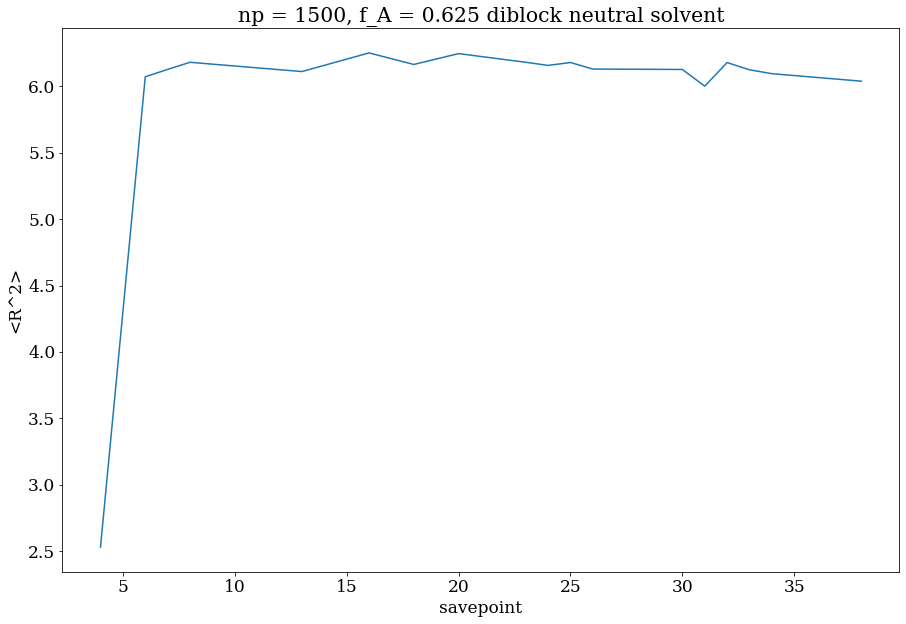

In [398]:
plt.figure(figsize=(15,10))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 17}
plt.rc('font', **font)

plt.plot(svpnt_val_list[2:], r2_ave[2:])

plt.title("np = 1500, f_A = 0.625 diblock neutral solvent")
plt.ylabel("<R^2>")
plt.xlabel("savepoint")

In [231]:
result

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.054638,0.053762,0.047600,0.051843,0.053189,0.053439,0.051730,0.056310,0.051074,0.056942,...,0.054388,0.057698,0.054079,0.055674,0.057837,0.061366,0.060409,0.052728,0.053564,0.065828
2,0.141340,0.129502,0.113332,0.105440,0.132301,0.144299,0.112326,0.134407,0.112867,0.112938,...,0.123609,0.121356,0.128143,0.138779,0.168453,0.145984,0.150122,0.120417,0.119412,0.148762
3,0.255385,0.171124,0.197385,0.211868,0.249118,0.225179,0.184961,0.238769,0.170569,0.168079,...,0.167434,0.209613,0.191833,0.206878,0.195184,0.208937,0.239875,0.185332,0.196101,0.256476
4,0.408036,0.325701,0.321313,0.268062,0.313076,0.344958,0.264434,0.243702,0.214787,0.241541,...,0.317381,0.279601,0.288803,0.255042,0.317278,0.219106,0.343262,0.271137,0.232235,0.337098
5,0.601470,0.377176,0.447426,0.335251,0.550304,0.406419,0.397390,0.433147,0.325357,0.298694,...,0.362757,0.370573,0.373113,0.369613,0.460386,0.319727,0.559627,0.519764,0.405381,0.406447
6,0.740756,0.455645,0.621792,0.392787,0.533673,0.548557,0.521944,0.571177,0.497491,0.319528,...,0.404122,0.528382,0.561092,0.426403,0.582512,0.373441,0.604956,0.396526,0.394716,0.577601
7,1.066207,0.627938,0.462955,0.472642,0.697358,0.729137,0.520082,0.668458,0.542661,0.431156,...,0.715243,0.730225,0.716489,0.964286,0.805404,0.496479,0.644139,0.588917,0.633461,0.645383
8,1.101962,0.710833,0.608918,0.703927,0.990495,1.040724,0.784266,0.644260,0.677444,0.524293,...,0.707065,0.919455,1.027578,0.668740,0.746635,0.678353,1.086672,0.799543,0.597043,0.873206
9,1.350582,0.664435,0.864793,0.820623,0.923097,1.016624,0.874375,0.572570,0.678071,0.632367,...,0.542848,1.061973,1.133063,0.774834,0.994101,0.832428,1.380921,0.754841,0.786572,0.980877


In [285]:
r2_ave_vect, result = r2(poly_ntwrk_list[-1][1])

processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250


In [287]:
print(r2_ave_vect[-1])
#result 

6.039054051092891


In [79]:
# r2_ave_vect, result = r2(no_interactions)

In [20]:
print(r2_ave_vect)
result 

[ 0.          0.16151278  0.59243728  1.24522628  2.07954993  3.06723617
  4.16569789  5.38538837  6.6487218   7.99208484  9.43793932 10.91659667
 12.37818563 13.89308667 15.4362178  17.04347128 18.64487326 20.22891804
 21.86025942 23.50434944 24.94745151 26.62523187 28.29599453 29.94128328
 31.55428672 33.20252514 34.84755739 36.54806549 38.21162255 39.91101385
 41.60153843 43.23246742 44.83438119 46.43516301 48.01264577 49.62889591
 51.19779563 52.80529516 54.39301144 56.05036629]


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.157959,0.147473,0.162123,0.171162,0.162561,0.162067,0.161183,0.154522,0.170941,0.160492,...,0.151643,0.160275,0.164059,0.162455,0.164502,0.158164,0.166980,0.166170,0.167712,0.165205
2,0.574533,0.549160,0.584291,0.626571,0.616642,0.601353,0.595330,0.565054,0.620521,0.593195,...,0.551825,0.585822,0.610149,0.601800,0.609381,0.566848,0.625966,0.593470,0.630145,0.595209
3,1.155976,1.179395,1.214368,1.318761,1.276532,1.260369,1.230608,1.188685,1.311302,1.233289,...,1.217028,1.286766,1.291160,1.268626,1.297717,1.218394,1.254425,1.288799,1.303457,1.255706
4,2.002388,1.891087,2.092197,2.065103,2.271605,2.145827,2.012835,1.760094,2.125436,2.012604,...,1.989987,2.051770,2.246046,2.029045,2.312009,2.095656,2.166242,2.149006,2.363098,1.950021
5,2.718192,2.596062,2.963646,3.143028,3.352720,3.179280,2.946224,2.635450,3.060645,2.772549,...,3.017031,3.008510,3.284773,3.197441,3.237589,2.838998,2.926162,3.253156,3.167626,2.635641
6,3.841749,3.502546,4.018099,4.069769,4.222490,4.509687,3.687525,3.610766,4.294624,3.938173,...,4.040649,3.386335,4.564999,4.418388,4.731706,3.881189,3.829188,3.867371,4.363755,3.849555
7,5.468836,3.956770,5.277126,4.600353,5.480911,5.530452,5.266811,4.162948,5.190584,4.970776,...,5.364221,5.052126,5.778548,5.732843,6.450962,5.051290,6.144148,5.324831,6.092218,4.531792
8,6.759105,5.748485,7.181959,5.340157,6.071908,6.127135,6.328008,5.391625,6.886879,6.510991,...,7.253022,5.963385,6.944149,7.423521,8.355813,6.506519,7.374955,7.837888,6.254794,4.540583
9,7.181217,6.738717,6.911374,8.573450,8.030048,8.277606,7.343234,7.277459,7.836084,7.823021,...,9.385375,6.737436,8.080345,7.645197,9.727783,8.614129,8.895220,7.710424,7.497201,5.639447


In [21]:
#wlc: kuhn length b ~= 2 * persistence length
kuhn_l = 2 * no_interactions.persistence_length
print(kuhn_l)
print(r2_ave_vect[1])

4.06
0.16151277946048911


## Plotting Simulation mean R^2 values vs wlc_stat ideal

polymer of 2 beads corresponds to one bead spacing 0-----0

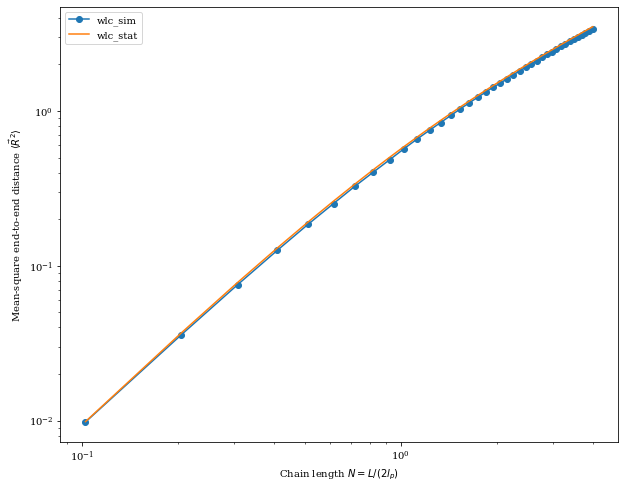

'\nISSUES:\nfrom wlcsim defines: 1 bead spacing squared = 0.174 simulation units\nmean square end-to-end distance of 2 bead polymer (1 jump) = 0.162 sim units\n\nHow much error is expected?\n'

In [55]:

#get wlc_sim r2 output nondimensionalized
nondimensionalization_constant = (2*no_interactions.persistence_length)**2
sim_r2_vals = r2_ave_vect[1:]/nondimensionalization_constant # nondimensionalized <r^2>

#get polymer lengths in terms of kuhn lengths (x-axis of plot)
bead_spacing = 16.26/39        # WLC_P__L / (WLC_P_NB - 1) == polymer length / num beads - 1. in simulation units 
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)
for i in range(1, 40):
    sim_chain_lengths[i-1] = bead_spacing_nm * i
    
length_kuhn = sim_chain_lengths / (2 * no_interactions.persistence_length * 28.7) #chain lengths from nm to Kuhn

r2_length_kuhn = length_kuhn
#get wlc_stat r2 output
dimensions = 3
stat_r2_vals = wlcave.r2_ave(length_kuhn, dimensions)

#plot
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)
plt.loglog(length_kuhn, sim_r2_vals, label="wlc_sim", marker = "o") #WLC SIM
plt.loglog(length_kuhn, stat_r2_vals, label="wlc_stat")  #WLC STAT
#print("sim chain lenghts: ", sim_chain_lengths)
#print("sim r2 vals: ", sim_r2_vals)
plt.xlabel(r'Chain length $N = L/(2l_{p})$')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square end-to-end distance $\langle \vec{R}^{2} \rangle$')
#plt.tight_layout()
plt.legend()
plt.show()

'''
ISSUES:
from wlcsim defines: 1 bead spacing squared = 0.174 simulation units
mean square end-to-end distance of 2 bead polymer (1 jump) = 0.162 sim units

How much error is expected?
'''

# Radius of Gyration:

have two functions to calculate it
### rg2 uses center of mass

### rg2_new uses interbead distances

In [25]:
'''
New radius of gyration based on interbead distance formula
'''
def rg2_new(polymer_network, skip_parameter=0):
    '''
    skip parameter is now how many beads to skip'''
    
    num_poly = len(polymer_network.polymer_list)
    rg2_all_pos_polymers = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        bead_dist = create_polymer_r2_table(poly)
        rg2_all_pos_polymers[i] = create_polymer_rg2_array_new(poly, bead_dist)
        if i%250 == 0:
            print("processed bead: ", i)
    #average the radii across all dif polymers in network
    num_beads = polymer_network.beads_per_polymer
    rg2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(rg2_all_pos_polymers.iloc[i]) # average size i jump over all polymers
        rg2_ave_vect[i] = row_avg
    
    return rg2_ave_vect, rg2_all_pos_polymers

    
def create_polymer_rg2_array_new(polymer, bead_dist, skip_parameter=0):
    num_beads = len(polymer.bead_list)
    rg2_vals = np.zeros(num_beads)
    for size in range(1, num_beads+1): # for all subpoly sizes. size = num beads in subpol
        num_subpolymers = num_beads//size
        for i in range(0, num_beads, size): # for all poss subpolys of given size
            
            #get the relevant submatrix
            sub_polymer_bead_dist = bead_dist[i+skip_parameter:i+size+skip_parameter, i+skip_parameter:i+size+skip_parameter] #sub polymer with i number of beads ()
            
            #get the sum of the matrix (upper triangular)
            if len(sub_polymer_bead_dist[0]) == size:
                displacement_sum = 0
                for i in range(size):
                    displacement_sum += np.sum(np.diag(sub_polymer_bead_dist, i))
            
                #calculate rg2
                subpol_num_beads = size
                subpol_rg2 = displacement_sum / (subpol_num_beads**2)
                rg2_vals[size-1] += subpol_rg2 / num_subpolymers
            
    return rg2_vals

In [26]:
# bead_dist = create_polymer_r2_table(poly)
# print(bead_dist[0:10])

In [27]:
# #For hand-calculating rg2new

# poly = no_interactions.polymer_list[1400]

# num_beads = len(poly.bead_list)
# for size in range(1, num_beads+1): # for all subpoly sizes. size = num beads in subpol
#     num_subpolymers = num_beads//size
#     print("size: ", size)
#     for i in range(0, num_beads, size): # for all poss subpolys of given size
#         #get the relevant submatrix
#         sub_polymer_bead_dist = bead_dist[i:i+size, i:i+size] #sub polymer with i number of beads ()
#         #get the sum of the matrix (upper triangular)
#         print (sub_polymer_bead_dist)
        
#         displacement_sum = 0
#         for i in range(size):
#                 displacement_sum += np.sum(np.diag(sub_polymer_bead_dist, i))
#         print(displacement_sum)
#         #calculate rg2

In [32]:
'''
Determine the mean square radius of gyration
Input: PolymerNetwork
       int skip_parameter: ratio of how many non-overlapping jumps of size d to skip when calculating the mean square 
       displacemnt between two beads distance d away. 1 means include all non-overlapping jumps,
       2 means every other, 3 means every third, etc.
Return: A DataFrame where the columns are a specific polymer in the network, rows are the size (number of bonds)
        of a given subpolymer,
        and the values are average radii of gyration of non-overlapping subpolymers of 
        a given size(averaged over all different jumps of that size possible in the polymer)

'''
def rg2(polymer_network, skip_parameter=1):
        
    num_poly = len(polymer_network.polymer_list)
    rg2_all_pos_polymers = pd.DataFrame(index=range(polymer_network.beads_per_polymer), columns=range(num_poly))
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating array of square radii of gyrations for a given polymer (and all possible subpolymers)
        rg2_all_pos_polymers[i] = create_polymer_rg2_array(poly, skip_parameter)
        
        if (i % 250 == 0):
            print("processed polymer " + str(i))
    
    #average the radii across all dif polymers in network
    num_beads = polymer_network.beads_per_polymer
    rg2_ave_vect = np.zeros(num_beads)
    for i in range(num_beads):
        row_avg = np.average(rg2_all_pos_polymers.iloc[i]) # average size i jump over all polymers
        rg2_ave_vect[i] = row_avg
    
    return rg2_ave_vect, rg2_all_pos_polymers


def create_polymer_rg2_array(polymer, skip_parameter=1):
    '''
    Populates an array with the average radii of gyration squared of the polymer and every possible non-overlapping
    subpolymer

    The index of the returned array indicates the size of the subpolymer (# of bonds), so that
    the value at an index i is average radius of gyration of non-overlapping subpolymers of size i
    '''
    num_beads = len(polymer.bead_list)                         
    rg2_subpolymers = np.zeros(num_beads)     
    #polymer.print_bead_list()
    for size in range(1, num_beads+1):   # for all sub polymer sizes. size = num beads in subpolymer
        #print("size: ", size)
        num_subpolymers = num_beads//size # ADD SKIP PARAM IN DENOMINATOR HERE!
        if size == 1: #one bead in polymer, so rg2 =0 - make program run faster
            rg2_subpolymers[size-1] = 0
        else:
            for i in range(0, num_beads, size): #for all non-overlapping subpolymers. 
                sub_bead_list = polymer.bead_list[i:i + size] ##ADD SKIP PARAM HERE
                if len(sub_bead_list) == size:  #leftover parts of matrix not included
                    sub_polymer = Polymer(sub_bead_list)
                    #print("subpolymer bead list:")
                    #sub_polymer.print_bead_list()
                    radius_g_2 = sub_polymer.Radius_of_gyration_2()
                    #print("subpolymer rg2: ", radius_g_2)
                    rg2_subpolymers[size-1] += radius_g_2/(num_subpolymers)  

    return rg2_subpolymers


In [33]:
# #create_polymer_rg2_array logic
# polymer = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# num_beads = len(polymer)
# for d in range(1, num_beads+1):
#     print("d = ", d)
#     for i in range(0, num_beads, d):
#         sub_bead_list = polymer[i:i + d]
#         print("subpolymer: ", sub_bead_list)
        

In [34]:
# #For hand-calculating rg2
# poly = no_interactions.polymer_list[1400]
# create_polymer_rg2_array(poly)

In [40]:
rg2_ave_vect, result = rg2(no_interactions)

processed polymer 0
processed polymer 250
processed polymer 500
processed polymer 750
processed polymer 1000
processed polymer 1250
processed polymer 1500
processed polymer 1750


In [41]:
result


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.041412,0.036620,0.041449,0.042382,0.040465,0.039344,0.040801,0.037810,0.042891,0.040639,...,0.038705,0.039252,0.042224,0.041275,0.042304,0.042607,0.042140,0.041594,0.040682,0.042920
2,0.094731,0.092401,0.101459,0.105937,0.101563,0.100917,0.098338,0.097702,0.104776,0.102127,...,0.090467,0.107590,0.104220,0.102335,0.099744,0.097585,0.108670,0.107856,0.109915,0.106987
3,0.180465,0.167416,0.181453,0.176562,0.192914,0.170524,0.183697,0.171097,0.190140,0.184094,...,0.166607,0.189848,0.185881,0.185686,0.190267,0.180303,0.186162,0.186688,0.204668,0.192674
4,0.278935,0.256651,0.262125,0.302886,0.283864,0.289613,0.282209,0.264236,0.292641,0.269456,...,0.280439,0.282624,0.265663,0.284374,0.279585,0.275653,0.282678,0.288557,0.303628,0.292783
5,0.367081,0.340213,0.395052,0.406057,0.412499,0.419704,0.369957,0.367465,0.374851,0.356883,...,0.375078,0.363284,0.390321,0.393603,0.412751,0.353686,0.389529,0.376297,0.419065,0.389275
6,0.529340,0.423712,0.529613,0.468248,0.534672,0.527843,0.522835,0.437695,0.524387,0.495741,...,0.489555,0.494773,0.542256,0.533545,0.599996,0.512002,0.581632,0.537261,0.538067,0.498173
7,0.640500,0.578313,0.690067,0.668281,0.643203,0.607892,0.651070,0.588086,0.732999,0.625794,...,0.634934,0.625010,0.651388,0.730114,0.705800,0.630391,0.682514,0.699127,0.685181,0.579425
8,0.812796,0.662582,0.767828,0.867041,0.827075,0.783673,0.767422,0.767979,0.781306,0.783361,...,0.852192,0.756681,0.788423,0.829898,0.873619,0.795429,0.938954,0.829134,0.788575,0.650042
9,0.886138,0.841877,0.918959,1.021824,0.967735,0.954957,0.928229,0.894274,0.951104,0.977118,...,1.034019,0.936591,0.907072,0.992576,1.042576,1.054628,0.984993,0.894993,1.071750,0.927744


**** for a single polymer *****

In [54]:
'''
Creates a 2D array with the square distance from each bead to each other bead in a polymer.
Inputs: Polymer class
Returns: 2D array of square distances
'''
def create_polymer_r2_table(polymer):
    num_beads = len(polymer.bead_list)
    bead_dist = np.zeros((num_beads, num_beads))
    for i, bead in enumerate(polymer.bead_coor_array):
        displacements = polymer.bead_coor_array - bead
        displacements_square = np.square(displacements)
        final_disp = np.sum(displacements_square, axis=1)
        bead_dist[i, :] = final_disp

    return bead_dist

'''
New radius of gyration based on interbead distance formula
'''
def rg2_single(polymer_network, skip_parameter=0):
    '''
    find mean square radius of gyration of a polymer network
    skip parameter is now how many beads to skip'''
    
    num_poly = len(polymer_network.polymer_list)
    rg2_all_polymers = np.zeros(num_poly)
    
    for i, poly in enumerate(polymer_network.polymer_list):
        # creating matrix of (inter-bead distances)^2 for a given polymer
        bead_dist = create_polymer_r2_table(poly)
        val = find_polymer_rg2(poly, bead_dist)
        rg2_all_polymers[i] = val
        if i%250 == 0:
            print("processed poly: ", i)

    print(rg2_all_polymers)
    rg2_ave = np.average(rg2_all_polymers) 
    
    return rg2_ave, rg2_all_polymers

    
def find_polymer_rg2(polymer, bead_dist, skip_parameter=0):
    num_beads = len(polymer.bead_list)
    displacement_sum = 0
    for i in range(num_beads):
        displacement_sum += np.sum(np.diag(bead_dist, i))
            
    #calculate rg2
    pol_rg2 = displacement_sum / (num_beads**2)
    return pol_rg2

In [55]:
rg2_ave, result_df = rg2_single(no_interactions)

processed poly:  0
processed poly:  250
processed poly:  500
processed poly:  750
processed poly:  1000
processed poly:  1250
processed poly:  1500
processed poly:  1750
[7.38482965 6.62759729 8.39657834 ... 8.12978946 5.57425073 6.13866734]


In [58]:
print(rg2_ave)

7.83693595724833


ALTERNATE MUCH SIMPLER WAY

In [60]:
rad_g = np.array([])
for polymer in no_interactions.polymer_list:
    rad_g = np.append(rad_g, polymer.Radius_of_gyration_2())
np.average(rad_g)

7.83693595724833

In [65]:
no_interactions.find_rg2()

7.83693595724833

**** ^^for a single polymer^^ *****

In [57]:
rg2_ave_vect_new, result_new = rg2_new(no_interactions)

processed poly:  0
processed poly:  250
processed poly:  500
processed poly:  750
processed poly:  1000
processed poly:  1250
processed poly:  1500
processed poly:  1750
[7.38482965 6.62759729 8.39657834 ... 8.12978946 5.57425073 6.13866734]


In [43]:
print(rg2_ave_vect_new)

[0.         0.04040731 0.10179213 0.18226466 0.27989841 0.39231403
 0.51982947 0.65851077 0.80669431 0.9676535  1.13861614 1.31606095
 1.4998934  1.69045634 1.88960244 2.09485439 2.30403144 2.51682794
 2.7332337  2.95241728 3.16008644 3.38818565 3.61965442 3.85359044
 4.08894499 4.32646416 4.56609123 4.80893791 5.05380477 5.30120003
 5.55073075 5.80136448 6.05295435 6.30543541 6.55846534 6.81282365
 7.06752698 7.32329969 7.57951183 7.83693596]


In [44]:
print(rg2_ave_vect)

[0.         0.04040731 0.10179213 0.18226466 0.27989841 0.39231403
 0.51982947 0.65851077 0.80669431 0.9676535  1.13861614 1.31606095
 1.4998934  1.69045634 1.88960244 2.09485439 2.30403144 2.51682794
 2.7332337  2.95241728 3.16008644 3.38818565 3.61965442 3.85359044
 4.08894499 4.32646416 4.56609123 4.80893791 5.05380477 5.30120003
 5.55073075 5.80136448 6.05295435 6.30543541 6.55846534 6.81282365
 7.06752698 7.32329969 7.57951183 7.83693596]


In [47]:
dif_array = rg2_ave_vect_new - rg2_ave_vect
print(dif_array)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.22044605e-16  0.00000000e+00
  0.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.88178420e-16
  8.88178420e-16  0.00000000e+00  0.00000000e+00 -8.88178420e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


Plotting Simulation mean Rg^2 values vs wlc_stat ideal

# ISSUE:
Can't find any math/coding errors in calculation of rg2 or rg2_new (using both formulas, both functions have matching output)


hand calculations of radius of gyration for 2 bead polymer matches program output(as in, does not match wlc stat 
output. )


## So, issue must be with matching number of beads to length of polymer?



 
## polymer of 2 beads corresponds to 2 bead spacings 
0-----0-----

LNTGTH O SIM RG@ VALS 39
0.0032449991810548084


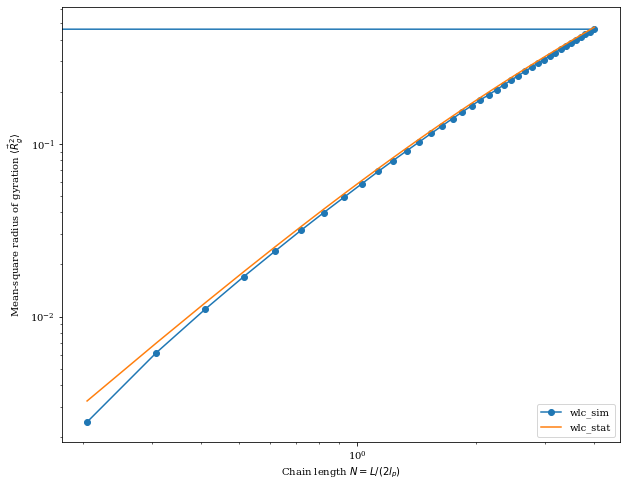

In [56]:

#get wlc_sim rg2 output normailized
nondimensionalization_constant = (2*no_interactions.persistence_length)**2
sim_rg2_vals = rg2_ave_vect[1:]/nondimensionalization_constant # nondimensionalized <r^2>
print("LNTGTH O SIM RG@ VALS", len(sim_rg2_vals))
#get polymer lengths in terms of kuhn lengths (x-axis of plot)
bead_spacing = 16.26/39        # WLC_P__L / (WLC_P_NB - 1) == polymer length / num beads - 1. in simulation units 
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)
for i in range(2, 40): #cahnged from range(1...), [i-1]
    sim_chain_lengths[i-2] = bead_spacing_nm * i
    
length_kuhn = sim_chain_lengths / (2 * no_interactions.persistence_length * 28.7) #chain lengths from nm to Kuhn

rg2_double_spacing = length_kuhn
#get wlc_stat rg2 output
dimensions = 3
stat_rg2_vals = wlcave.rg2_ave(length_kuhn, dimensions)
print(stat_rg2_vals[0])
#plot
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)

plt.loglog(length_kuhn, sim_rg2_vals, label="wlc_sim", marker="o") #WLC SIM
plt.loglog(length_kuhn, stat_rg2_vals, label="wlc_stat")  #WLC STAT
#print("sim chain lenghts: ", sim_chain_lengths)
#print("sim r2 vals: ", sim_r2_vals)
plt.xlabel(r'Chain length $N = L/(2l_{p})$')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square radius of gyration $\langle \vec{R}_g^{2} \rangle$')
#plt.tight_layout()
plt.legend()
plt.show()


In [49]:
print(sim_rg2_vals)
print(stat_rg2_vals)

[0.00245136 0.00617536 0.01105733 0.01698042 0.02380026 0.03153616
 0.03994945 0.04893921 0.05870401 0.0690757  0.07984063 0.09099307
 0.10255383 0.1146353  0.12708719 0.1397772  0.15268679 0.16581534
 0.17911241 0.19171094 0.20554889 0.21959126 0.2337833  0.24806141
 0.26247083 0.27700813 0.29174076 0.30659594 0.32160451 0.33674263
 0.35194766 0.3672107  0.38252781 0.39787821 0.41330921 0.42876113
 0.44427793 0.45982139 0.47543837]
[0.003245   0.00702629 0.01203292 0.01812932 0.02519663 0.03313046
 0.04183904 0.05124152 0.0612666  0.07185133 0.08293998 0.0944832
 0.10643719 0.11876303 0.13142607 0.14439543 0.15764353 0.1711457
 0.18487986 0.1988262  0.2129669  0.22728595 0.24176891 0.25640274
 0.27117567 0.28607702 0.30109713 0.3162272  0.33145924 0.34678599
 0.3622008  0.37769761 0.39327087 0.40891551 0.42462686 0.44040065
 0.45623294 0.4721201         nan]



## polymer of 2 beads corresponds to one bead spacing
0-----0



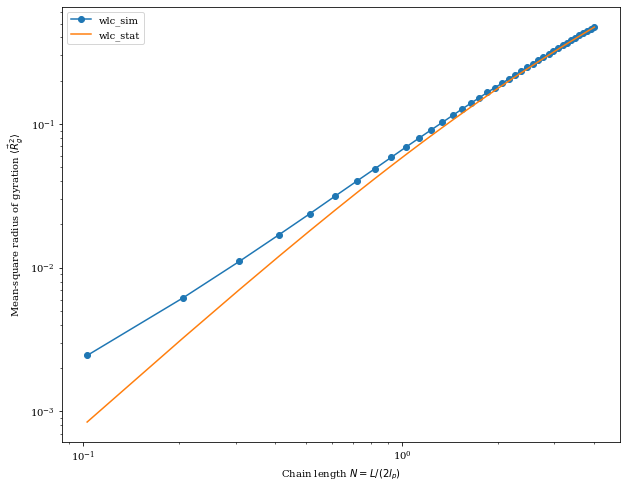

'\nISSUES:\nat low chain length, high error.\nHow much error is expected?\n'

In [57]:
#get wlc_sim rg2 output normailized
nondimensionalization_constant = (2*no_interactions.persistence_length)**2
sim_rg2_vals_new = rg2_ave_vect_new[1:]/nondimensionalization_constant # nondimensionalized <r^2>
#get polymer lengths in terms of kuhn lengths (x-axis of plot)
bead_spacing = 16.26/39        # WLC_P__L / (WLC_P_NB - 1) == polymer length / num beads - 1. in simulation units 
bead_spacing_nm = bead_spacing * 28.7 # 1 simulation unit = 28.7 nm

sim_chain_lengths = np.zeros(39)
for i in range(1, 40):
    sim_chain_lengths[i-1] = bead_spacing_nm * i
    
length_kuhn = sim_chain_lengths / (2 * no_interactions.persistence_length * 28.7) #chain lengths from nm to Kuhn
rg2_normal_spacing = length_kuhn
#get wlc_stat rg2 output
dimensions = 3
stat_rg2_vals = wlcave.rg2_ave(length_kuhn, dimensions)
#print(stat_rg2_vals[0])
#plot
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 10}
plt.rc('font', **font)
plt.loglog(length_kuhn, sim_rg2_vals_new, label="wlc_sim", marker = "o") #WLC SIM
plt.loglog(length_kuhn, stat_rg2_vals, label="wlc_stat")  #WLC STAT
#print("sim chain lenghts: ", sim_chain_lengths)
#print("sim r2 vals: ", sim_r2_vals)
plt.xlabel(r'Chain length $N = L/(2l_{p})$')# $N = L/(2l_{p})$')
plt.ylabel(r'Mean-square radius of gyration $\langle \vec{R}_g^{2} \rangle$')
#plt.tight_layout()
plt.legend()
plt.show()
'''
ISSUES:
at low chain length, high error.
How much error is expected?
'''

In [58]:
print(sim_rg2_vals)
print(stat_rg2_vals)

[0.00245136 0.00617536 0.01105733 0.01698042 0.02380026 0.03153616
 0.03994945 0.04893921 0.05870401 0.0690757  0.07984063 0.09099307
 0.10255383 0.1146353  0.12708719 0.1397772  0.15268679 0.16581534
 0.17911241 0.19171094 0.20554889 0.21959126 0.2337833  0.24806141
 0.26247083 0.27700813 0.29174076 0.30659594 0.32160451 0.33674263
 0.35194766 0.3672107  0.38252781 0.39787821 0.41330921 0.42876113
 0.44427793 0.45982139 0.47543837]
[0.00084388 0.003245   0.00702629 0.01203292 0.01812932 0.02519663
 0.03313046 0.04183904 0.05124152 0.0612666  0.07185133 0.08293998
 0.0944832  0.10643719 0.11876303 0.13142607 0.14439543 0.15764353
 0.1711457  0.18487986 0.1988262  0.2129669  0.22728595 0.24176891
 0.25640274 0.27117567 0.28607702 0.30109713 0.3162272  0.33145924
 0.34678599 0.3622008  0.37769761 0.39327087 0.40891551 0.42462686
 0.44040065 0.45623294 0.4721201 ]


In [60]:
print(r2_length_kuhn)      # 0-----0
print(rg2_normal_spacing)  # 0-----0
print(rg2_double_spacing)  # 0-----0-----

[0.10269041 0.20538083 0.30807124 0.41076165 0.51345207 0.61614248
 0.71883289 0.8215233  0.92421372 1.02690413 1.12959454 1.23228496
 1.33497537 1.43766578 1.5403562  1.64304661 1.74573702 1.84842743
 1.95111785 2.05380826 2.15649867 2.25918909 2.3618795  2.46456991
 2.56726033 2.66995074 2.77264115 2.87533156 2.97802198 3.08071239
 3.1834028  3.28609322 3.38878363 3.49147404 3.59416446 3.69685487
 3.79954528 3.9022357  4.00492611]
[0.10269041 0.20538083 0.30807124 0.41076165 0.51345207 0.61614248
 0.71883289 0.8215233  0.92421372 1.02690413 1.12959454 1.23228496
 1.33497537 1.43766578 1.5403562  1.64304661 1.74573702 1.84842743
 1.95111785 2.05380826 2.15649867 2.25918909 2.3618795  2.46456991
 2.56726033 2.66995074 2.77264115 2.87533156 2.97802198 3.08071239
 3.1834028  3.28609322 3.38878363 3.49147404 3.59416446 3.69685487
 3.79954528 3.9022357  4.00492611]
[0.20538083 0.30807124 0.41076165 0.51345207 0.61614248 0.71883289
 0.8215233  0.92421372 1.02690413 1.12959454 1.23228496 1.3

Hand calculations and two rg2 functions confirm that for 2 beads, rg2 is on the order of 10^-3 

I am interpreting the length of a 2 bead polymer as one interbead spacing (0-----0)

this is the same as n the mean end to end distance plot.


However, the wlcstat output for one interbead length polymer is order 10^-4.
Where is the error
